# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [2]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

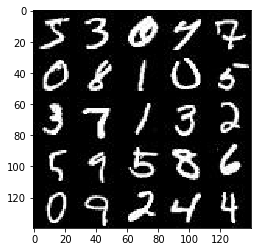

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

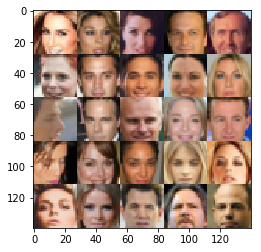

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0


C:\Users\Mohammad\Anaconda2\envs\tensorflow\lib\site-packages\ipykernel\__main__.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function

    inputs = tf.placeholder(tf.float32, shape=[None, image_width, image_height, image_channels])
    input_z = tf.placeholder(tf.float32, shape=[None, z_dim])
    learning_rate = tf.placeholder(tf.float32)
    
    return (inputs, input_z, learning_rate)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [122]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    
    alpha = 0.2
    with tf.variable_scope('discriminator', reuse=reuse):
        
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        
#         x4 = tf.layers.conv2d(relu3, 512, 5, strides=2, padding='same')
#         bn4 = tf.layers.batch_normalization(x4, training=True)
#         relu4 = tf.maximum(alpha * bn4, bn4)
        
#         x5 = tf.layers.conv2d(relu4, 1024, 5, strides=2, padding='same')
#         bn5 = tf.layers.batch_normalization(x5, training=True)
#         relu5 = tf.maximum(alpha * bn5, bn5)
 
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return (out, logits)
    


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [133]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope('generator', reuse=not is_train):
        
        
#         x1 = tf.layers.dense(z, 14*14*1024)
#         x1 = tf.reshape(x1, (-1, 14, 14, 1024))
#         x1 = tf.layers.batch_normalization(x1, training=is_train)
#         x1 = tf.maximum(alpha * x1, x1)
        
        x1 = tf.layers.dense(z, 7*7*256)
        x1 = tf.reshape(x1, (-1, 7, 7, 256))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        
#         x2 = tf.layers.conv2d_transpose(x1, 512, 5, strides=1, padding='SAME')
#         x2 = tf.layers.batch_normalization(x2, training=is_train)
#         x2 = tf.maximum(alpha * x2, x2)
        
#         x3 = tf.layers.conv2d_transpose(x2, 256, 5, strides=1, padding='SAME')
#         x3 = tf.layers.batch_normalization(x3, training=is_train)
#         x3 = tf.maximum(alpha * x3, x3)
        
        x4 = tf.layers.conv2d_transpose(x1, 128, 5, strides=1, padding='SAME')
        x4 = tf.layers.batch_normalization(x4, training=is_train)
        x4 = tf.maximum(alpha * x4, x4)
        
        x5 = tf.layers.conv2d_transpose(x4, 64, 5, strides=2, padding='SAME')
        x5 = tf.layers.batch_normalization(x5, training=is_train)
        x5 = tf.maximum(alpha * x5, x5)
        
        
        
        logits = tf.layers.conv2d_transpose(x5, out_channel_dim, 5, strides=2, padding='SAME')
        print(out_channel_dim)
        return tf.tanh(logits)
        
        


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

5
5
Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [63]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
#     alpha = 0.2
    
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

4
Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [64]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]


    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [65]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [66]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model

    input_real, input_z, learn_rate = model_inputs(data_shape[1],  data_shape[2],  data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    samples = []
    losses = []
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                
                print_every = 10
                show_every = 100
                show_img = 20
                steps += 1
                batch_images = batch_images * 2
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, learn_rate: learning_rate})

                if steps % print_every == 0:

                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    losses.append((train_loss_d, train_loss_g))


                if steps % show_every == 0:
                    show_generator_output(sess, show_img, input_z, data_shape[3], data_image_mode)
                    
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

1
Epoch 1/2... Discriminator Loss: 3.0785... Generator Loss: 0.3719
Epoch 1/2... Discriminator Loss: 0.2852... Generator Loss: 1.9950
Epoch 1/2... Discriminator Loss: 4.7145... Generator Loss: 5.4106
Epoch 1/2... Discriminator Loss: 1.4947... Generator Loss: 0.8773
Epoch 1/2... Discriminator Loss: 2.2400... Generator Loss: 0.2154
Epoch 1/2... Discriminator Loss: 0.8760... Generator Loss: 1.1761
Epoch 1/2... Discriminator Loss: 2.3506... Generator Loss: 0.1646
Epoch 1/2... Discriminator Loss: 1.1723... Generator Loss: 0.7473
Epoch 1/2... Discriminator Loss: 0.9006... Generator Loss: 1.0252
Epoch 1/2... Discriminator Loss: 1.1196... Generator Loss: 1.0322
1


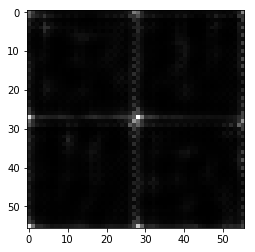

Epoch 1/2... Discriminator Loss: 2.5127... Generator Loss: 0.1326
Epoch 1/2... Discriminator Loss: 1.2360... Generator Loss: 2.1989
Epoch 1/2... Discriminator Loss: 1.1577... Generator Loss: 0.7369
Epoch 1/2... Discriminator Loss: 1.9012... Generator Loss: 0.3167
Epoch 1/2... Discriminator Loss: 1.7713... Generator Loss: 1.0729
Epoch 1/2... Discriminator Loss: 1.0017... Generator Loss: 0.9122
Epoch 1/2... Discriminator Loss: 1.1894... Generator Loss: 0.6774
Epoch 1/2... Discriminator Loss: 1.1169... Generator Loss: 1.4334
Epoch 1/2... Discriminator Loss: 1.2863... Generator Loss: 0.6238
Epoch 1/2... Discriminator Loss: 1.0528... Generator Loss: 0.8894
1


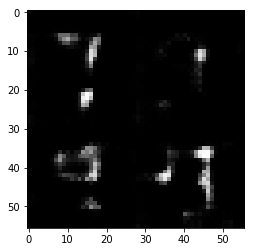

Epoch 1/2... Discriminator Loss: 0.8321... Generator Loss: 2.4054
Epoch 1/2... Discriminator Loss: 2.2661... Generator Loss: 0.2076
Epoch 1/2... Discriminator Loss: 1.1523... Generator Loss: 0.9979
Epoch 1/2... Discriminator Loss: 2.7156... Generator Loss: 0.1209
Epoch 1/2... Discriminator Loss: 1.4415... Generator Loss: 0.4536
Epoch 1/2... Discriminator Loss: 1.2038... Generator Loss: 0.6780
Epoch 1/2... Discriminator Loss: 0.7637... Generator Loss: 1.8306
Epoch 1/2... Discriminator Loss: 1.5191... Generator Loss: 0.6327
Epoch 1/2... Discriminator Loss: 1.1223... Generator Loss: 0.6385
Epoch 1/2... Discriminator Loss: 0.7684... Generator Loss: 2.1273
1


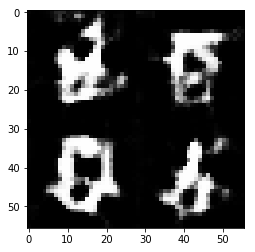

Epoch 1/2... Discriminator Loss: 0.3863... Generator Loss: 1.7628
Epoch 1/2... Discriminator Loss: 1.1892... Generator Loss: 0.8962
Epoch 1/2... Discriminator Loss: 1.1478... Generator Loss: 0.5886
Epoch 1/2... Discriminator Loss: 1.0576... Generator Loss: 0.5941
Epoch 1/2... Discriminator Loss: 1.1940... Generator Loss: 0.9715
Epoch 1/2... Discriminator Loss: 1.5647... Generator Loss: 0.4561
Epoch 1/2... Discriminator Loss: 1.2006... Generator Loss: 0.5061
Epoch 1/2... Discriminator Loss: 1.0848... Generator Loss: 0.7621
Epoch 1/2... Discriminator Loss: 1.7887... Generator Loss: 0.4363
Epoch 1/2... Discriminator Loss: 1.7467... Generator Loss: 0.3233
1


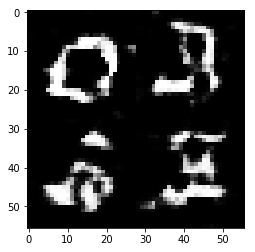

Epoch 1/2... Discriminator Loss: 2.2952... Generator Loss: 0.2682
Epoch 1/2... Discriminator Loss: 0.6942... Generator Loss: 2.0742
Epoch 1/2... Discriminator Loss: 0.8718... Generator Loss: 1.4595
Epoch 1/2... Discriminator Loss: 2.2688... Generator Loss: 0.1994
Epoch 1/2... Discriminator Loss: 0.6648... Generator Loss: 1.7172
Epoch 1/2... Discriminator Loss: 1.0072... Generator Loss: 1.2008
Epoch 1/2... Discriminator Loss: 2.0118... Generator Loss: 0.2439
Epoch 1/2... Discriminator Loss: 1.2629... Generator Loss: 0.6491
Epoch 1/2... Discriminator Loss: 1.6970... Generator Loss: 0.3182
Epoch 1/2... Discriminator Loss: 1.7486... Generator Loss: 0.3046
1


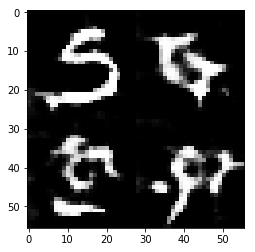

Epoch 1/2... Discriminator Loss: 1.3245... Generator Loss: 0.4730
Epoch 1/2... Discriminator Loss: 1.2866... Generator Loss: 0.6069
Epoch 1/2... Discriminator Loss: 0.9606... Generator Loss: 0.9877
Epoch 1/2... Discriminator Loss: 0.7266... Generator Loss: 1.0266
Epoch 1/2... Discriminator Loss: 2.6229... Generator Loss: 0.1096
Epoch 1/2... Discriminator Loss: 1.7504... Generator Loss: 0.3104
Epoch 1/2... Discriminator Loss: 0.9063... Generator Loss: 1.0832
Epoch 1/2... Discriminator Loss: 1.6051... Generator Loss: 0.5224
Epoch 1/2... Discriminator Loss: 0.4758... Generator Loss: 1.7185
Epoch 1/2... Discriminator Loss: 0.8394... Generator Loss: 1.0388
1


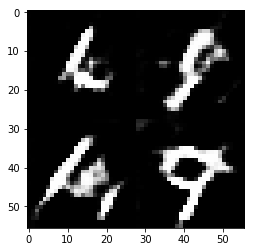

Epoch 1/2... Discriminator Loss: 1.0929... Generator Loss: 0.7535
Epoch 1/2... Discriminator Loss: 1.4580... Generator Loss: 0.5328
Epoch 1/2... Discriminator Loss: 1.3977... Generator Loss: 0.5436
Epoch 1/2... Discriminator Loss: 0.9020... Generator Loss: 1.1239
Epoch 1/2... Discriminator Loss: 1.9838... Generator Loss: 0.2290
Epoch 1/2... Discriminator Loss: 0.9545... Generator Loss: 0.9321
Epoch 1/2... Discriminator Loss: 1.1007... Generator Loss: 1.1708
Epoch 1/2... Discriminator Loss: 2.0279... Generator Loss: 0.3197
Epoch 1/2... Discriminator Loss: 0.9868... Generator Loss: 0.9712
Epoch 1/2... Discriminator Loss: 0.9254... Generator Loss: 0.8295
1


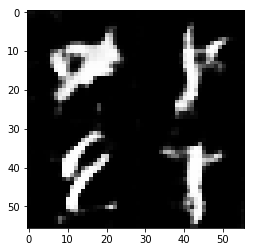

Epoch 1/2... Discriminator Loss: 0.5861... Generator Loss: 1.9857
Epoch 1/2... Discriminator Loss: 1.1312... Generator Loss: 0.6154
Epoch 1/2... Discriminator Loss: 0.5081... Generator Loss: 1.3274
Epoch 1/2... Discriminator Loss: 0.6274... Generator Loss: 1.3391
Epoch 1/2... Discriminator Loss: 0.8040... Generator Loss: 0.9932
Epoch 1/2... Discriminator Loss: 1.1729... Generator Loss: 0.6346
Epoch 1/2... Discriminator Loss: 0.8359... Generator Loss: 0.9325
Epoch 1/2... Discriminator Loss: 1.0364... Generator Loss: 0.7555
Epoch 1/2... Discriminator Loss: 1.8931... Generator Loss: 0.3054
Epoch 1/2... Discriminator Loss: 1.3890... Generator Loss: 0.5201
1


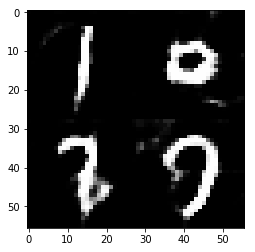

Epoch 1/2... Discriminator Loss: 0.3988... Generator Loss: 2.9943
Epoch 1/2... Discriminator Loss: 0.6726... Generator Loss: 1.2400
Epoch 1/2... Discriminator Loss: 0.9227... Generator Loss: 1.3533
Epoch 1/2... Discriminator Loss: 0.5593... Generator Loss: 3.7200
Epoch 1/2... Discriminator Loss: 0.7774... Generator Loss: 2.3990
Epoch 1/2... Discriminator Loss: 0.6850... Generator Loss: 1.2891
Epoch 1/2... Discriminator Loss: 0.8401... Generator Loss: 1.3176
Epoch 1/2... Discriminator Loss: 0.4027... Generator Loss: 1.8127
Epoch 1/2... Discriminator Loss: 0.5439... Generator Loss: 1.5988
Epoch 1/2... Discriminator Loss: 0.4329... Generator Loss: 1.6176
1


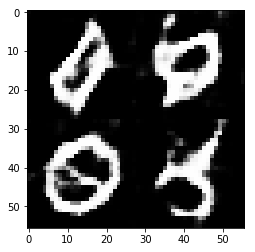

Epoch 1/2... Discriminator Loss: 0.4853... Generator Loss: 1.9190
Epoch 1/2... Discriminator Loss: 1.2648... Generator Loss: 0.5248
Epoch 1/2... Discriminator Loss: 0.9973... Generator Loss: 0.7298
Epoch 2/2... Discriminator Loss: 0.6463... Generator Loss: 2.6240
Epoch 2/2... Discriminator Loss: 1.2423... Generator Loss: 0.6645
Epoch 2/2... Discriminator Loss: 0.8184... Generator Loss: 1.0631
Epoch 2/2... Discriminator Loss: 1.0172... Generator Loss: 0.8462
Epoch 2/2... Discriminator Loss: 1.9192... Generator Loss: 0.2821
Epoch 2/2... Discriminator Loss: 0.8064... Generator Loss: 1.0237
Epoch 2/2... Discriminator Loss: 0.9356... Generator Loss: 0.8010
1


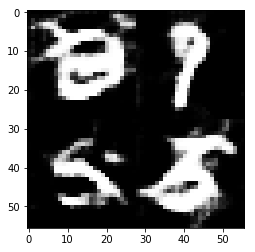

Epoch 2/2... Discriminator Loss: 0.9321... Generator Loss: 1.0090
Epoch 2/2... Discriminator Loss: 0.8673... Generator Loss: 1.0520
Epoch 2/2... Discriminator Loss: 0.7072... Generator Loss: 1.2463
Epoch 2/2... Discriminator Loss: 0.6597... Generator Loss: 1.2011
Epoch 2/2... Discriminator Loss: 0.5721... Generator Loss: 1.6104
Epoch 2/2... Discriminator Loss: 1.6680... Generator Loss: 0.5789
Epoch 2/2... Discriminator Loss: 0.8208... Generator Loss: 0.9740
Epoch 2/2... Discriminator Loss: 0.9375... Generator Loss: 0.9594
Epoch 2/2... Discriminator Loss: 0.8542... Generator Loss: 1.0499
Epoch 2/2... Discriminator Loss: 1.1226... Generator Loss: 0.6550
1


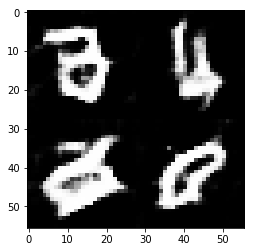

Epoch 2/2... Discriminator Loss: 1.7893... Generator Loss: 0.5755
Epoch 2/2... Discriminator Loss: 0.5929... Generator Loss: 1.2359
Epoch 2/2... Discriminator Loss: 0.6240... Generator Loss: 1.4233
Epoch 2/2... Discriminator Loss: 0.4647... Generator Loss: 1.4485
Epoch 2/2... Discriminator Loss: 0.3758... Generator Loss: 1.9185
Epoch 2/2... Discriminator Loss: 0.7174... Generator Loss: 1.5954
Epoch 2/2... Discriminator Loss: 0.8087... Generator Loss: 0.9359
Epoch 2/2... Discriminator Loss: 1.1273... Generator Loss: 0.5626
Epoch 2/2... Discriminator Loss: 0.4572... Generator Loss: 2.3114
Epoch 2/2... Discriminator Loss: 0.2740... Generator Loss: 2.4783
1


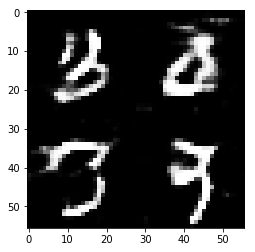

Epoch 2/2... Discriminator Loss: 0.3497... Generator Loss: 2.4363
Epoch 2/2... Discriminator Loss: 0.5950... Generator Loss: 1.5886
Epoch 2/2... Discriminator Loss: 1.4417... Generator Loss: 0.5132
Epoch 2/2... Discriminator Loss: 0.5555... Generator Loss: 1.4396
Epoch 2/2... Discriminator Loss: 0.6924... Generator Loss: 3.8174
Epoch 2/2... Discriminator Loss: 0.2254... Generator Loss: 2.2647
Epoch 2/2... Discriminator Loss: 0.4964... Generator Loss: 2.1841
Epoch 2/2... Discriminator Loss: 2.9869... Generator Loss: 0.1335
Epoch 2/2... Discriminator Loss: 0.7373... Generator Loss: 1.5445
Epoch 2/2... Discriminator Loss: 1.2232... Generator Loss: 0.6087
1


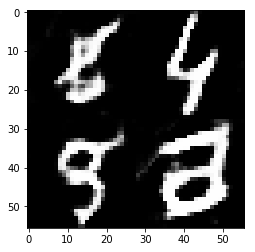

Epoch 2/2... Discriminator Loss: 0.5558... Generator Loss: 1.3814
Epoch 2/2... Discriminator Loss: 2.1631... Generator Loss: 0.2957
Epoch 2/2... Discriminator Loss: 0.6298... Generator Loss: 1.2562
Epoch 2/2... Discriminator Loss: 0.5818... Generator Loss: 1.3249
Epoch 2/2... Discriminator Loss: 1.6955... Generator Loss: 0.3608
Epoch 2/2... Discriminator Loss: 0.7819... Generator Loss: 1.0621
Epoch 2/2... Discriminator Loss: 0.2838... Generator Loss: 2.4901
Epoch 2/2... Discriminator Loss: 0.9628... Generator Loss: 0.6885
Epoch 2/2... Discriminator Loss: 1.6336... Generator Loss: 0.4383
Epoch 2/2... Discriminator Loss: 1.6318... Generator Loss: 0.6206
1


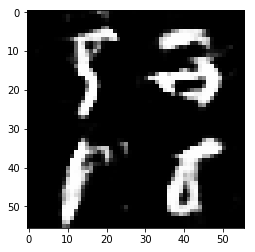

Epoch 2/2... Discriminator Loss: 2.0607... Generator Loss: 0.4389
Epoch 2/2... Discriminator Loss: 0.8329... Generator Loss: 0.9052
Epoch 2/2... Discriminator Loss: 0.4232... Generator Loss: 1.3138
Epoch 2/2... Discriminator Loss: 0.2981... Generator Loss: 2.1448
Epoch 2/2... Discriminator Loss: 0.4943... Generator Loss: 1.6595
Epoch 2/2... Discriminator Loss: 1.2446... Generator Loss: 0.6017
Epoch 2/2... Discriminator Loss: 0.6892... Generator Loss: 1.3994
Epoch 2/2... Discriminator Loss: 1.0904... Generator Loss: 0.8528
Epoch 2/2... Discriminator Loss: 0.8472... Generator Loss: 0.9321
Epoch 2/2... Discriminator Loss: 0.3103... Generator Loss: 2.3201
1


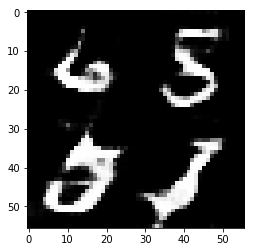

Epoch 2/2... Discriminator Loss: 0.6826... Generator Loss: 1.2846
Epoch 2/2... Discriminator Loss: 0.8609... Generator Loss: 1.0734
Epoch 2/2... Discriminator Loss: 0.6238... Generator Loss: 1.1753
Epoch 2/2... Discriminator Loss: 0.2827... Generator Loss: 1.9699
Epoch 2/2... Discriminator Loss: 0.4755... Generator Loss: 1.2352
Epoch 2/2... Discriminator Loss: 0.6276... Generator Loss: 1.7087
Epoch 2/2... Discriminator Loss: 0.6667... Generator Loss: 1.5270
Epoch 2/2... Discriminator Loss: 0.5341... Generator Loss: 1.5623
Epoch 2/2... Discriminator Loss: 0.6479... Generator Loss: 1.2740
Epoch 2/2... Discriminator Loss: 4.5743... Generator Loss: 0.0305
1


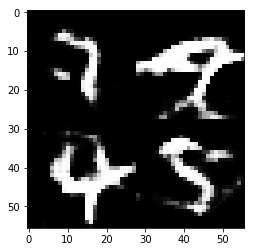

Epoch 2/2... Discriminator Loss: 0.3776... Generator Loss: 1.8667
Epoch 2/2... Discriminator Loss: 0.2456... Generator Loss: 2.6086
Epoch 2/2... Discriminator Loss: 1.0188... Generator Loss: 0.8140
Epoch 2/2... Discriminator Loss: 0.6476... Generator Loss: 3.6496
Epoch 2/2... Discriminator Loss: 0.3994... Generator Loss: 1.9468
Epoch 2/2... Discriminator Loss: 0.5235... Generator Loss: 1.3893
Epoch 2/2... Discriminator Loss: 0.6108... Generator Loss: 1.1431
Epoch 2/2... Discriminator Loss: 0.5047... Generator Loss: 2.0663
Epoch 2/2... Discriminator Loss: 0.4318... Generator Loss: 1.3500
Epoch 2/2... Discriminator Loss: 0.7635... Generator Loss: 1.3158
1


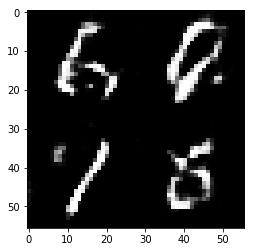

Epoch 2/2... Discriminator Loss: 0.5546... Generator Loss: 1.3612
Epoch 2/2... Discriminator Loss: 0.3642... Generator Loss: 2.0039
Epoch 2/2... Discriminator Loss: 1.5858... Generator Loss: 0.3649
Epoch 2/2... Discriminator Loss: 0.9860... Generator Loss: 1.4567
Epoch 2/2... Discriminator Loss: 0.6890... Generator Loss: 1.7385
Epoch 2/2... Discriminator Loss: 0.5972... Generator Loss: 1.5798
Epoch 2/2... Discriminator Loss: 1.2009... Generator Loss: 0.5565
Epoch 2/2... Discriminator Loss: 0.6844... Generator Loss: 1.9005
Epoch 2/2... Discriminator Loss: 1.0813... Generator Loss: 0.7208
Epoch 2/2... Discriminator Loss: 0.5751... Generator Loss: 3.7803
1


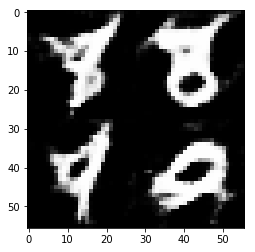

Epoch 2/2... Discriminator Loss: 0.6484... Generator Loss: 1.0367
Epoch 2/2... Discriminator Loss: 0.6342... Generator Loss: 1.3157
Epoch 2/2... Discriminator Loss: 0.5007... Generator Loss: 1.7742
Epoch 2/2... Discriminator Loss: 0.9033... Generator Loss: 0.9792
Epoch 2/2... Discriminator Loss: 0.4196... Generator Loss: 3.1130
Epoch 2/2... Discriminator Loss: 0.8738... Generator Loss: 0.8191
Epoch 2/2... Discriminator Loss: 1.1100... Generator Loss: 0.5346


In [127]:
batch_size = 64
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

3
Epoch 1/2... Discriminator Loss: 1.5657... Generator Loss: 0.5546
Epoch 1/2... Discriminator Loss: 0.3474... Generator Loss: 3.1835
Epoch 1/2... Discriminator Loss: 11.4612... Generator Loss: 0.0000
Epoch 1/2... Discriminator Loss: 4.0204... Generator Loss: 9.6017
Epoch 1/2... Discriminator Loss: 0.6658... Generator Loss: 1.5601
Epoch 1/2... Discriminator Loss: 1.1103... Generator Loss: 4.4951
Epoch 1/2... Discriminator Loss: 0.6371... Generator Loss: 1.2089
Epoch 1/2... Discriminator Loss: 1.8715... Generator Loss: 0.2710
Epoch 1/2... Discriminator Loss: 0.8297... Generator Loss: 1.6813
Epoch 1/2... Discriminator Loss: 0.6531... Generator Loss: 1.3253
3


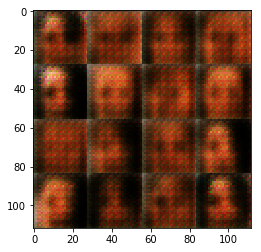

Epoch 1/2... Discriminator Loss: 0.8541... Generator Loss: 1.2839
Epoch 1/2... Discriminator Loss: 1.0788... Generator Loss: 0.8276
Epoch 1/2... Discriminator Loss: 2.7280... Generator Loss: 0.1226
Epoch 1/2... Discriminator Loss: 1.0050... Generator Loss: 0.7228
Epoch 1/2... Discriminator Loss: 1.5444... Generator Loss: 0.3958
Epoch 1/2... Discriminator Loss: 1.1033... Generator Loss: 0.6095
Epoch 1/2... Discriminator Loss: 0.8884... Generator Loss: 2.1865
Epoch 1/2... Discriminator Loss: 0.8947... Generator Loss: 0.9237
Epoch 1/2... Discriminator Loss: 1.7927... Generator Loss: 0.3081
Epoch 1/2... Discriminator Loss: 0.6677... Generator Loss: 1.4218
3


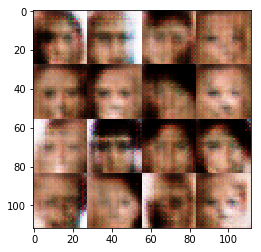

Epoch 1/2... Discriminator Loss: 0.6438... Generator Loss: 1.8423
Epoch 1/2... Discriminator Loss: 1.0043... Generator Loss: 0.9309
Epoch 1/2... Discriminator Loss: 0.3938... Generator Loss: 1.7942
Epoch 1/2... Discriminator Loss: 0.8640... Generator Loss: 0.8189
Epoch 1/2... Discriminator Loss: 0.9279... Generator Loss: 0.6560
Epoch 1/2... Discriminator Loss: 1.1578... Generator Loss: 0.6529
Epoch 1/2... Discriminator Loss: 1.0205... Generator Loss: 0.6509
Epoch 1/2... Discriminator Loss: 0.7479... Generator Loss: 1.4078
Epoch 1/2... Discriminator Loss: 1.2793... Generator Loss: 0.6524
Epoch 1/2... Discriminator Loss: 1.2701... Generator Loss: 1.4293
3


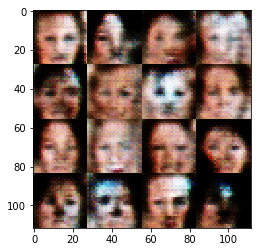

Epoch 1/2... Discriminator Loss: 0.9887... Generator Loss: 0.8308
Epoch 1/2... Discriminator Loss: 0.6949... Generator Loss: 2.0516
Epoch 1/2... Discriminator Loss: 0.6397... Generator Loss: 2.0820
Epoch 1/2... Discriminator Loss: 0.7306... Generator Loss: 1.1494
Epoch 1/2... Discriminator Loss: 1.1167... Generator Loss: 0.5780
Epoch 1/2... Discriminator Loss: 1.9303... Generator Loss: 3.7606
Epoch 1/2... Discriminator Loss: 0.7971... Generator Loss: 0.9719
Epoch 1/2... Discriminator Loss: 0.8687... Generator Loss: 0.8900
Epoch 1/2... Discriminator Loss: 0.3775... Generator Loss: 1.5153
Epoch 1/2... Discriminator Loss: 0.6590... Generator Loss: 1.0748
3


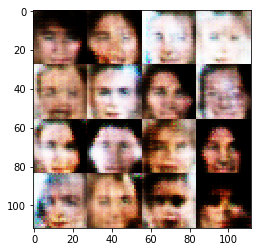

Epoch 1/2... Discriminator Loss: 1.1147... Generator Loss: 1.3188
Epoch 1/2... Discriminator Loss: 0.9022... Generator Loss: 0.8710
Epoch 1/2... Discriminator Loss: 1.2974... Generator Loss: 0.4570
Epoch 1/2... Discriminator Loss: 1.4675... Generator Loss: 0.3427
Epoch 1/2... Discriminator Loss: 0.8268... Generator Loss: 1.6751
Epoch 1/2... Discriminator Loss: 0.7465... Generator Loss: 1.3093
Epoch 1/2... Discriminator Loss: 1.2965... Generator Loss: 0.4345
Epoch 1/2... Discriminator Loss: 0.9284... Generator Loss: 1.2200
Epoch 1/2... Discriminator Loss: 1.1457... Generator Loss: 2.6733
Epoch 1/2... Discriminator Loss: 1.1417... Generator Loss: 0.5090
3


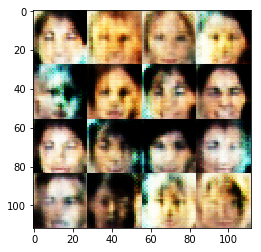

Epoch 1/2... Discriminator Loss: 0.6842... Generator Loss: 0.9910
Epoch 1/2... Discriminator Loss: 0.8296... Generator Loss: 1.6646
Epoch 1/2... Discriminator Loss: 0.9624... Generator Loss: 3.9756
Epoch 1/2... Discriminator Loss: 1.1457... Generator Loss: 0.6290
Epoch 1/2... Discriminator Loss: 0.4306... Generator Loss: 1.6324
Epoch 1/2... Discriminator Loss: 0.6790... Generator Loss: 2.0080
Epoch 1/2... Discriminator Loss: 0.3021... Generator Loss: 1.6545
Epoch 1/2... Discriminator Loss: 1.6609... Generator Loss: 1.4290
Epoch 1/2... Discriminator Loss: 0.4755... Generator Loss: 1.5463
Epoch 1/2... Discriminator Loss: 1.1346... Generator Loss: 0.5741
3


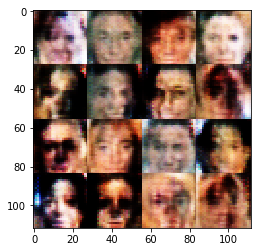

Epoch 1/2... Discriminator Loss: 0.6331... Generator Loss: 1.1648
Epoch 1/2... Discriminator Loss: 0.8866... Generator Loss: 1.5820
Epoch 1/2... Discriminator Loss: 0.5636... Generator Loss: 1.0345
Epoch 1/2... Discriminator Loss: 1.0253... Generator Loss: 0.6601
Epoch 1/2... Discriminator Loss: 0.9317... Generator Loss: 0.8350
Epoch 1/2... Discriminator Loss: 0.5544... Generator Loss: 3.0292
Epoch 1/2... Discriminator Loss: 0.8716... Generator Loss: 0.7069
Epoch 1/2... Discriminator Loss: 1.3637... Generator Loss: 0.4328
Epoch 1/2... Discriminator Loss: 1.5406... Generator Loss: 0.3502
Epoch 1/2... Discriminator Loss: 0.4497... Generator Loss: 1.8009
3


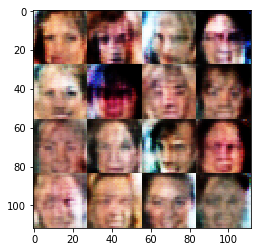

Epoch 1/2... Discriminator Loss: 0.7579... Generator Loss: 0.8859
Epoch 1/2... Discriminator Loss: 0.5447... Generator Loss: 1.1663
Epoch 1/2... Discriminator Loss: 0.2769... Generator Loss: 2.7648
Epoch 1/2... Discriminator Loss: 0.2892... Generator Loss: 1.7770
Epoch 1/2... Discriminator Loss: 0.4261... Generator Loss: 3.2768
Epoch 1/2... Discriminator Loss: 0.8975... Generator Loss: 1.5607
Epoch 1/2... Discriminator Loss: 1.1056... Generator Loss: 1.2788
Epoch 1/2... Discriminator Loss: 0.8057... Generator Loss: 1.6413
Epoch 1/2... Discriminator Loss: 1.4357... Generator Loss: 0.4073
Epoch 1/2... Discriminator Loss: 0.2650... Generator Loss: 2.4823
3


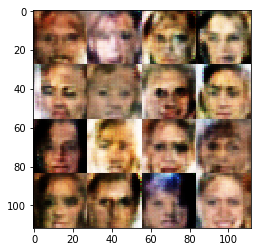

Epoch 1/2... Discriminator Loss: 0.4226... Generator Loss: 1.3718
Epoch 1/2... Discriminator Loss: 0.1419... Generator Loss: 4.2343
Epoch 1/2... Discriminator Loss: 0.6634... Generator Loss: 0.9219
Epoch 1/2... Discriminator Loss: 0.9885... Generator Loss: 0.8387
Epoch 1/2... Discriminator Loss: 0.6347... Generator Loss: 1.7106
Epoch 1/2... Discriminator Loss: 0.9190... Generator Loss: 0.7647
Epoch 1/2... Discriminator Loss: 2.7629... Generator Loss: 4.4463
Epoch 1/2... Discriminator Loss: 0.5248... Generator Loss: 2.3321
Epoch 1/2... Discriminator Loss: 0.2941... Generator Loss: 1.6820
Epoch 1/2... Discriminator Loss: 0.6384... Generator Loss: 0.9802
3


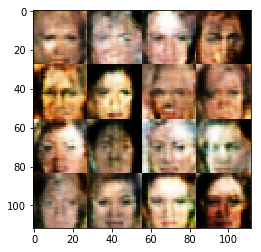

Epoch 1/2... Discriminator Loss: 0.7538... Generator Loss: 0.8295
Epoch 1/2... Discriminator Loss: 0.4347... Generator Loss: 2.0678
Epoch 1/2... Discriminator Loss: 0.2372... Generator Loss: 2.1100
Epoch 1/2... Discriminator Loss: 0.3225... Generator Loss: 1.7757
Epoch 1/2... Discriminator Loss: 0.1800... Generator Loss: 2.7495
Epoch 1/2... Discriminator Loss: 2.0141... Generator Loss: 2.5135
Epoch 1/2... Discriminator Loss: 0.8436... Generator Loss: 0.9544
Epoch 1/2... Discriminator Loss: 0.8830... Generator Loss: 0.7728
Epoch 1/2... Discriminator Loss: 0.8617... Generator Loss: 1.0526
Epoch 1/2... Discriminator Loss: 0.6782... Generator Loss: 1.9365
3


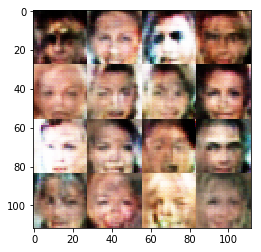

Epoch 1/2... Discriminator Loss: 0.8099... Generator Loss: 2.8774
Epoch 1/2... Discriminator Loss: 0.9330... Generator Loss: 0.6629
Epoch 1/2... Discriminator Loss: 0.5818... Generator Loss: 1.0051
Epoch 1/2... Discriminator Loss: 0.6016... Generator Loss: 1.1222
Epoch 1/2... Discriminator Loss: 0.2245... Generator Loss: 3.0182
Epoch 1/2... Discriminator Loss: 0.1986... Generator Loss: 3.4632
Epoch 1/2... Discriminator Loss: 0.3968... Generator Loss: 4.0873
Epoch 1/2... Discriminator Loss: 0.2032... Generator Loss: 2.1297
Epoch 1/2... Discriminator Loss: 0.1531... Generator Loss: 3.3687
Epoch 1/2... Discriminator Loss: 0.4848... Generator Loss: 1.5661
3


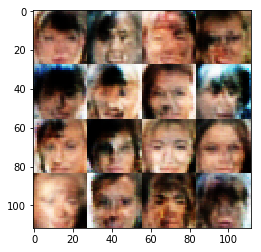

Epoch 1/2... Discriminator Loss: 0.5555... Generator Loss: 1.2411
Epoch 1/2... Discriminator Loss: 1.4254... Generator Loss: 0.3898
Epoch 1/2... Discriminator Loss: 0.7946... Generator Loss: 2.9421
Epoch 1/2... Discriminator Loss: 0.4463... Generator Loss: 2.2598
Epoch 1/2... Discriminator Loss: 1.7692... Generator Loss: 0.4090
Epoch 1/2... Discriminator Loss: 0.4904... Generator Loss: 1.3672
Epoch 1/2... Discriminator Loss: 0.9018... Generator Loss: 2.8675
Epoch 1/2... Discriminator Loss: 0.6931... Generator Loss: 1.0525
Epoch 1/2... Discriminator Loss: 0.2816... Generator Loss: 1.9922
Epoch 1/2... Discriminator Loss: 0.8706... Generator Loss: 2.4310
3


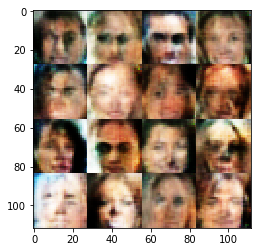

Epoch 1/2... Discriminator Loss: 0.3695... Generator Loss: 2.6133
Epoch 1/2... Discriminator Loss: 1.0471... Generator Loss: 0.8060
Epoch 1/2... Discriminator Loss: 0.6217... Generator Loss: 2.6296
Epoch 1/2... Discriminator Loss: 1.1032... Generator Loss: 0.6406
Epoch 1/2... Discriminator Loss: 0.9588... Generator Loss: 1.3331
Epoch 1/2... Discriminator Loss: 0.1776... Generator Loss: 2.8073
Epoch 1/2... Discriminator Loss: 0.0676... Generator Loss: 4.6130
Epoch 1/2... Discriminator Loss: 0.3879... Generator Loss: 4.5447
Epoch 1/2... Discriminator Loss: 0.1226... Generator Loss: 2.6640
Epoch 1/2... Discriminator Loss: 0.1027... Generator Loss: 3.2178
3


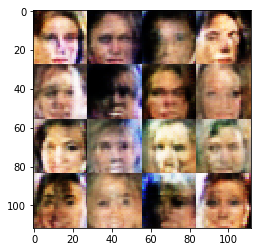

Epoch 1/2... Discriminator Loss: 0.6861... Generator Loss: 1.0916
Epoch 1/2... Discriminator Loss: 0.3352... Generator Loss: 2.4918
Epoch 1/2... Discriminator Loss: 0.8802... Generator Loss: 1.4349
Epoch 1/2... Discriminator Loss: 0.3190... Generator Loss: 1.7850
Epoch 1/2... Discriminator Loss: 0.9002... Generator Loss: 1.0083
Epoch 1/2... Discriminator Loss: 1.0029... Generator Loss: 0.6637
Epoch 1/2... Discriminator Loss: 0.1392... Generator Loss: 2.7568
Epoch 1/2... Discriminator Loss: 2.4304... Generator Loss: 5.2039
Epoch 1/2... Discriminator Loss: 0.5797... Generator Loss: 1.8687
Epoch 1/2... Discriminator Loss: 0.2059... Generator Loss: 2.7188
3


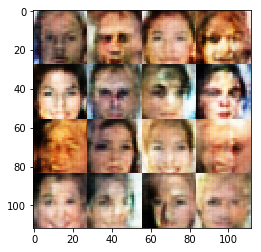

Epoch 1/2... Discriminator Loss: 0.4739... Generator Loss: 1.7861
Epoch 1/2... Discriminator Loss: 0.2682... Generator Loss: 1.9587
Epoch 1/2... Discriminator Loss: 0.5407... Generator Loss: 1.9678
Epoch 1/2... Discriminator Loss: 0.1544... Generator Loss: 3.1861
Epoch 1/2... Discriminator Loss: 1.2041... Generator Loss: 0.6774
Epoch 1/2... Discriminator Loss: 0.9198... Generator Loss: 0.8728
Epoch 1/2... Discriminator Loss: 0.5862... Generator Loss: 1.4455
Epoch 1/2... Discriminator Loss: 0.8379... Generator Loss: 1.0699
Epoch 1/2... Discriminator Loss: 0.4539... Generator Loss: 3.3614
Epoch 1/2... Discriminator Loss: 0.2645... Generator Loss: 1.9087
3


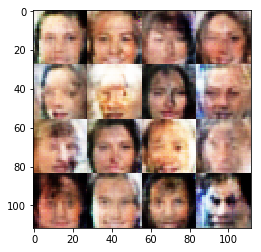

Epoch 1/2... Discriminator Loss: 0.0809... Generator Loss: 4.0230
Epoch 1/2... Discriminator Loss: 2.6396... Generator Loss: 0.1377
Epoch 1/2... Discriminator Loss: 0.6505... Generator Loss: 1.5551
Epoch 1/2... Discriminator Loss: 0.1192... Generator Loss: 4.2996
Epoch 1/2... Discriminator Loss: 0.3428... Generator Loss: 1.7754
Epoch 1/2... Discriminator Loss: 0.1033... Generator Loss: 5.0042
Epoch 1/2... Discriminator Loss: 0.0874... Generator Loss: 3.8421
Epoch 1/2... Discriminator Loss: 0.0591... Generator Loss: 4.0713
Epoch 1/2... Discriminator Loss: 0.7632... Generator Loss: 0.8230
Epoch 1/2... Discriminator Loss: 0.0386... Generator Loss: 4.1715
3


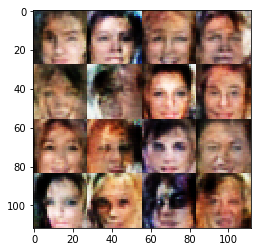

Epoch 1/2... Discriminator Loss: 0.1434... Generator Loss: 2.5671
Epoch 1/2... Discriminator Loss: 0.1622... Generator Loss: 2.6821
Epoch 1/2... Discriminator Loss: 0.6158... Generator Loss: 0.9394
Epoch 1/2... Discriminator Loss: 0.0491... Generator Loss: 6.3639
Epoch 1/2... Discriminator Loss: 0.0721... Generator Loss: 6.2065
Epoch 1/2... Discriminator Loss: 0.0887... Generator Loss: 3.2904
Epoch 1/2... Discriminator Loss: 0.0909... Generator Loss: 3.3753
Epoch 1/2... Discriminator Loss: 2.6701... Generator Loss: 0.2293
Epoch 1/2... Discriminator Loss: 0.6773... Generator Loss: 1.3548
Epoch 1/2... Discriminator Loss: 0.7622... Generator Loss: 1.1158
3


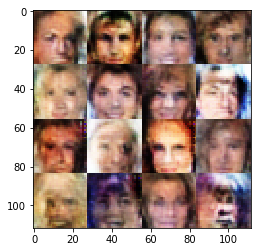

Epoch 1/2... Discriminator Loss: 0.7342... Generator Loss: 1.3686
Epoch 1/2... Discriminator Loss: 1.5489... Generator Loss: 0.4151
Epoch 1/2... Discriminator Loss: 1.6901... Generator Loss: 3.9497
Epoch 1/2... Discriminator Loss: 1.1808... Generator Loss: 1.4338
Epoch 1/2... Discriminator Loss: 0.9384... Generator Loss: 0.7672
Epoch 1/2... Discriminator Loss: 0.7626... Generator Loss: 1.7856
Epoch 1/2... Discriminator Loss: 0.5987... Generator Loss: 1.1151
Epoch 1/2... Discriminator Loss: 1.2209... Generator Loss: 0.5634
Epoch 1/2... Discriminator Loss: 1.2970... Generator Loss: 0.4646
Epoch 1/2... Discriminator Loss: 1.4243... Generator Loss: 0.4213
3


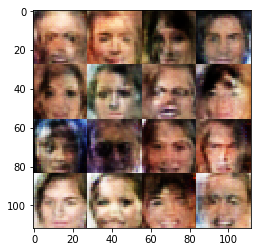

Epoch 1/2... Discriminator Loss: 1.0917... Generator Loss: 0.6394
Epoch 1/2... Discriminator Loss: 1.7175... Generator Loss: 0.2671
Epoch 1/2... Discriminator Loss: 0.9127... Generator Loss: 0.9529
Epoch 1/2... Discriminator Loss: 0.7852... Generator Loss: 1.2958
Epoch 1/2... Discriminator Loss: 1.2757... Generator Loss: 1.9449
Epoch 1/2... Discriminator Loss: 0.8368... Generator Loss: 0.9643
Epoch 1/2... Discriminator Loss: 0.9310... Generator Loss: 1.0569
Epoch 1/2... Discriminator Loss: 0.7727... Generator Loss: 0.9335
Epoch 1/2... Discriminator Loss: 0.9108... Generator Loss: 2.1293
Epoch 1/2... Discriminator Loss: 0.8015... Generator Loss: 1.1174
3


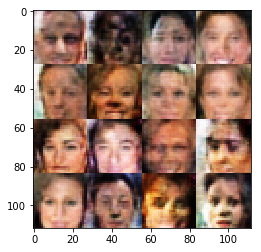

Epoch 1/2... Discriminator Loss: 0.7330... Generator Loss: 2.2684
Epoch 1/2... Discriminator Loss: 1.2133... Generator Loss: 0.6591
Epoch 1/2... Discriminator Loss: 0.7359... Generator Loss: 1.1754
Epoch 1/2... Discriminator Loss: 0.3084... Generator Loss: 1.7131
Epoch 1/2... Discriminator Loss: 2.0330... Generator Loss: 0.2109
Epoch 1/2... Discriminator Loss: 0.3110... Generator Loss: 3.4574
Epoch 1/2... Discriminator Loss: 0.5263... Generator Loss: 1.5426
Epoch 1/2... Discriminator Loss: 0.2972... Generator Loss: 1.9987
Epoch 1/2... Discriminator Loss: 0.3131... Generator Loss: 2.1219
Epoch 1/2... Discriminator Loss: 0.2860... Generator Loss: 2.1165
3


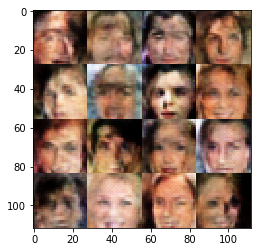

Epoch 1/2... Discriminator Loss: 0.6356... Generator Loss: 0.9950
Epoch 1/2... Discriminator Loss: 0.2571... Generator Loss: 2.8016
Epoch 1/2... Discriminator Loss: 0.4117... Generator Loss: 3.3614
Epoch 1/2... Discriminator Loss: 0.2131... Generator Loss: 2.7929
Epoch 1/2... Discriminator Loss: 2.5127... Generator Loss: 4.5781
Epoch 1/2... Discriminator Loss: 2.5044... Generator Loss: 0.1564
Epoch 1/2... Discriminator Loss: 0.2792... Generator Loss: 2.0561
Epoch 1/2... Discriminator Loss: 0.1595... Generator Loss: 2.7498
Epoch 1/2... Discriminator Loss: 1.9841... Generator Loss: 4.0567
Epoch 1/2... Discriminator Loss: 0.1370... Generator Loss: 3.1550
3


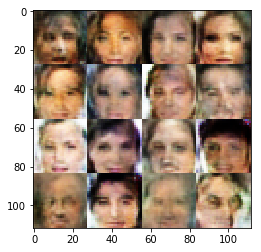

Epoch 1/2... Discriminator Loss: 0.9619... Generator Loss: 3.4910
Epoch 1/2... Discriminator Loss: 0.1909... Generator Loss: 2.8820
Epoch 1/2... Discriminator Loss: 0.1454... Generator Loss: 4.2187
Epoch 1/2... Discriminator Loss: 0.1600... Generator Loss: 3.2286
Epoch 1/2... Discriminator Loss: 0.4378... Generator Loss: 1.4240
Epoch 1/2... Discriminator Loss: 0.0682... Generator Loss: 5.3054
Epoch 1/2... Discriminator Loss: 0.0646... Generator Loss: 4.4748
Epoch 1/2... Discriminator Loss: 0.1157... Generator Loss: 2.9938
Epoch 1/2... Discriminator Loss: 0.0411... Generator Loss: 5.2696
Epoch 1/2... Discriminator Loss: 1.1542... Generator Loss: 3.5055
3


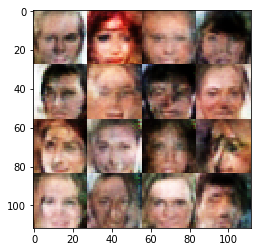

Epoch 1/2... Discriminator Loss: 0.2930... Generator Loss: 2.9403
Epoch 1/2... Discriminator Loss: 0.8809... Generator Loss: 1.8479
Epoch 1/2... Discriminator Loss: 0.5102... Generator Loss: 1.2584
Epoch 1/2... Discriminator Loss: 1.0807... Generator Loss: 0.6743
Epoch 1/2... Discriminator Loss: 0.1413... Generator Loss: 3.0371
Epoch 1/2... Discriminator Loss: 0.1370... Generator Loss: 3.2896
Epoch 1/2... Discriminator Loss: 0.1602... Generator Loss: 2.8738
Epoch 1/2... Discriminator Loss: 0.0884... Generator Loss: 4.2357
Epoch 1/2... Discriminator Loss: 0.0780... Generator Loss: 3.8958
Epoch 1/2... Discriminator Loss: 1.1755... Generator Loss: 0.5495
3


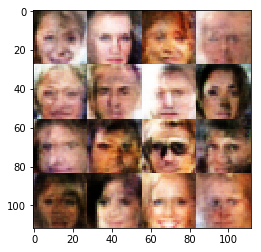

Epoch 1/2... Discriminator Loss: 0.7336... Generator Loss: 1.0490
Epoch 1/2... Discriminator Loss: 2.2144... Generator Loss: 5.3192
Epoch 1/2... Discriminator Loss: 0.4959... Generator Loss: 2.3007
Epoch 1/2... Discriminator Loss: 0.8968... Generator Loss: 2.0698
Epoch 1/2... Discriminator Loss: 0.6761... Generator Loss: 1.7356
Epoch 1/2... Discriminator Loss: 0.6145... Generator Loss: 1.0320
Epoch 1/2... Discriminator Loss: 0.8615... Generator Loss: 0.8734
Epoch 1/2... Discriminator Loss: 0.2562... Generator Loss: 2.3192
Epoch 1/2... Discriminator Loss: 0.9437... Generator Loss: 2.6190
Epoch 1/2... Discriminator Loss: 0.2584... Generator Loss: 2.3980
3


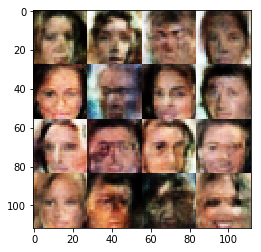

Epoch 1/2... Discriminator Loss: 0.3929... Generator Loss: 2.8677
Epoch 1/2... Discriminator Loss: 0.1872... Generator Loss: 2.3598
Epoch 1/2... Discriminator Loss: 0.3006... Generator Loss: 2.1814
Epoch 1/2... Discriminator Loss: 0.6682... Generator Loss: 0.9872
Epoch 1/2... Discriminator Loss: 1.7290... Generator Loss: 4.8012
Epoch 1/2... Discriminator Loss: 0.7474... Generator Loss: 0.9706
Epoch 1/2... Discriminator Loss: 0.4089... Generator Loss: 1.4317
Epoch 1/2... Discriminator Loss: 0.3553... Generator Loss: 1.8097
Epoch 1/2... Discriminator Loss: 0.1894... Generator Loss: 2.6268
Epoch 1/2... Discriminator Loss: 0.1070... Generator Loss: 4.5449
3


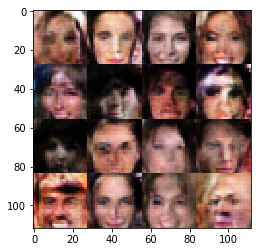

Epoch 1/2... Discriminator Loss: 0.0307... Generator Loss: 6.6947
Epoch 1/2... Discriminator Loss: 0.0856... Generator Loss: 3.3496
Epoch 1/2... Discriminator Loss: 0.0933... Generator Loss: 3.0188
Epoch 1/2... Discriminator Loss: 0.0593... Generator Loss: 4.0236
Epoch 1/2... Discriminator Loss: 0.2950... Generator Loss: 1.8695
Epoch 1/2... Discriminator Loss: 0.3681... Generator Loss: 1.8099
Epoch 1/2... Discriminator Loss: 0.0297... Generator Loss: 4.7269
Epoch 1/2... Discriminator Loss: 0.8591... Generator Loss: 0.8865
Epoch 1/2... Discriminator Loss: 0.8988... Generator Loss: 3.4712
Epoch 1/2... Discriminator Loss: 0.5185... Generator Loss: 1.3318
3


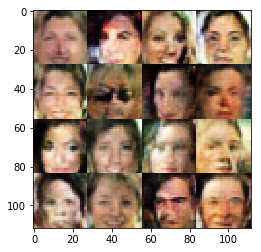

Epoch 1/2... Discriminator Loss: 0.1488... Generator Loss: 2.6653
Epoch 1/2... Discriminator Loss: 0.0826... Generator Loss: 3.8376
Epoch 1/2... Discriminator Loss: 1.0983... Generator Loss: 1.6002
Epoch 1/2... Discriminator Loss: 1.1240... Generator Loss: 0.6930
Epoch 1/2... Discriminator Loss: 0.0506... Generator Loss: 5.3562
Epoch 1/2... Discriminator Loss: 0.4915... Generator Loss: 2.5761
Epoch 1/2... Discriminator Loss: 0.3749... Generator Loss: 1.5695
Epoch 1/2... Discriminator Loss: 0.4792... Generator Loss: 1.3801
Epoch 1/2... Discriminator Loss: 0.1348... Generator Loss: 2.7667
Epoch 1/2... Discriminator Loss: 0.0426... Generator Loss: 4.5941
3


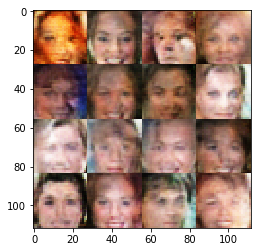

Epoch 1/2... Discriminator Loss: 3.4750... Generator Loss: 4.7115
Epoch 1/2... Discriminator Loss: 0.8306... Generator Loss: 1.9383
Epoch 1/2... Discriminator Loss: 0.0754... Generator Loss: 3.4899
Epoch 1/2... Discriminator Loss: 2.3079... Generator Loss: 8.5131
Epoch 1/2... Discriminator Loss: 0.2865... Generator Loss: 1.9081
Epoch 1/2... Discriminator Loss: 2.5706... Generator Loss: 0.1394
Epoch 1/2... Discriminator Loss: 0.6380... Generator Loss: 1.1979
Epoch 1/2... Discriminator Loss: 0.5549... Generator Loss: 1.2116
Epoch 1/2... Discriminator Loss: 0.9967... Generator Loss: 0.9175
Epoch 1/2... Discriminator Loss: 0.3576... Generator Loss: 1.6487
3


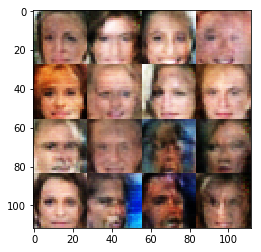

Epoch 1/2... Discriminator Loss: 0.3183... Generator Loss: 1.6817
Epoch 1/2... Discriminator Loss: 0.2861... Generator Loss: 1.9375
Epoch 1/2... Discriminator Loss: 0.0695... Generator Loss: 3.7713
Epoch 1/2... Discriminator Loss: 0.5350... Generator Loss: 1.3416
Epoch 1/2... Discriminator Loss: 0.3120... Generator Loss: 1.7368
Epoch 1/2... Discriminator Loss: 0.4535... Generator Loss: 2.7659
Epoch 1/2... Discriminator Loss: 0.2422... Generator Loss: 3.6018
Epoch 1/2... Discriminator Loss: 0.3241... Generator Loss: 1.9849
Epoch 1/2... Discriminator Loss: 0.2312... Generator Loss: 2.0536
Epoch 1/2... Discriminator Loss: 0.1278... Generator Loss: 2.9828
3


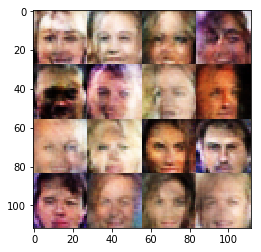

Epoch 1/2... Discriminator Loss: 0.3716... Generator Loss: 1.6202
Epoch 1/2... Discriminator Loss: 0.8526... Generator Loss: 0.8386
Epoch 1/2... Discriminator Loss: 0.2789... Generator Loss: 1.7030
Epoch 1/2... Discriminator Loss: 0.1310... Generator Loss: 2.5994
Epoch 1/2... Discriminator Loss: 0.0590... Generator Loss: 4.2329
Epoch 1/2... Discriminator Loss: 0.1617... Generator Loss: 2.4056
Epoch 1/2... Discriminator Loss: 1.5450... Generator Loss: 0.3535
Epoch 1/2... Discriminator Loss: 0.0738... Generator Loss: 3.5369
Epoch 1/2... Discriminator Loss: 2.4981... Generator Loss: 5.2263
Epoch 1/2... Discriminator Loss: 0.5679... Generator Loss: 1.5256
3


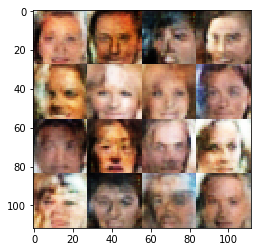

Epoch 1/2... Discriminator Loss: 1.2668... Generator Loss: 4.3042
Epoch 1/2... Discriminator Loss: 0.4388... Generator Loss: 3.6613
Epoch 1/2... Discriminator Loss: 0.3327... Generator Loss: 2.0715
Epoch 1/2... Discriminator Loss: 0.1399... Generator Loss: 2.7795
Epoch 1/2... Discriminator Loss: 0.6859... Generator Loss: 1.0067
Epoch 1/2... Discriminator Loss: 0.5689... Generator Loss: 3.8623
Epoch 1/2... Discriminator Loss: 0.2473... Generator Loss: 2.1007
Epoch 1/2... Discriminator Loss: 0.0372... Generator Loss: 7.8436
Epoch 1/2... Discriminator Loss: 0.0560... Generator Loss: 4.7818
Epoch 1/2... Discriminator Loss: 0.3084... Generator Loss: 2.7490
3


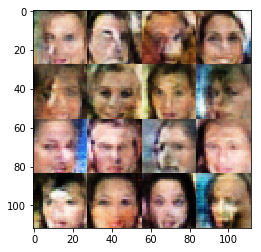

Epoch 1/2... Discriminator Loss: 0.0483... Generator Loss: 4.5846
Epoch 1/2... Discriminator Loss: 0.5584... Generator Loss: 1.1769
Epoch 1/2... Discriminator Loss: 0.4102... Generator Loss: 1.9870
Epoch 1/2... Discriminator Loss: 0.3827... Generator Loss: 1.7685
Epoch 1/2... Discriminator Loss: 0.8020... Generator Loss: 1.2187
Epoch 1/2... Discriminator Loss: 0.1080... Generator Loss: 4.5260
Epoch 2/2... Discriminator Loss: 0.0430... Generator Loss: 5.1736
Epoch 2/2... Discriminator Loss: 0.1141... Generator Loss: 2.9204
Epoch 2/2... Discriminator Loss: 0.1065... Generator Loss: 4.9766
Epoch 2/2... Discriminator Loss: 0.6089... Generator Loss: 3.7518
3


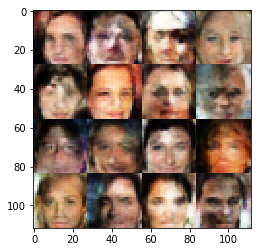

Epoch 2/2... Discriminator Loss: 0.1212... Generator Loss: 3.1749
Epoch 2/2... Discriminator Loss: 0.0391... Generator Loss: 5.4172
Epoch 2/2... Discriminator Loss: 3.5714... Generator Loss: 6.0467
Epoch 2/2... Discriminator Loss: 0.4927... Generator Loss: 1.5008
Epoch 2/2... Discriminator Loss: 0.6406... Generator Loss: 5.7484
Epoch 2/2... Discriminator Loss: 0.5858... Generator Loss: 4.3344
Epoch 2/2... Discriminator Loss: 0.2919... Generator Loss: 2.2116
Epoch 2/2... Discriminator Loss: 0.1301... Generator Loss: 2.9246
Epoch 2/2... Discriminator Loss: 0.0275... Generator Loss: 5.3112
Epoch 2/2... Discriminator Loss: 0.9318... Generator Loss: 3.5873
3


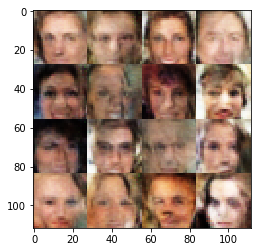

Epoch 2/2... Discriminator Loss: 0.8536... Generator Loss: 3.6551
Epoch 2/2... Discriminator Loss: 0.1669... Generator Loss: 2.7784
Epoch 2/2... Discriminator Loss: 2.4627... Generator Loss: 6.6603
Epoch 2/2... Discriminator Loss: 0.1479... Generator Loss: 2.7775
Epoch 2/2... Discriminator Loss: 0.2106... Generator Loss: 2.1881
Epoch 2/2... Discriminator Loss: 0.5120... Generator Loss: 1.8065
Epoch 2/2... Discriminator Loss: 0.8142... Generator Loss: 1.0306
Epoch 2/2... Discriminator Loss: 0.3386... Generator Loss: 2.4537
Epoch 2/2... Discriminator Loss: 0.6475... Generator Loss: 1.3475
Epoch 2/2... Discriminator Loss: 0.0822... Generator Loss: 3.4981
3


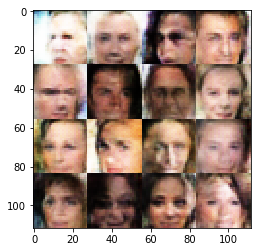

Epoch 2/2... Discriminator Loss: 0.8324... Generator Loss: 4.3976
Epoch 2/2... Discriminator Loss: 0.2668... Generator Loss: 2.2046
Epoch 2/2... Discriminator Loss: 0.1050... Generator Loss: 2.9301
Epoch 2/2... Discriminator Loss: 0.1585... Generator Loss: 2.8813
Epoch 2/2... Discriminator Loss: 0.5440... Generator Loss: 4.8245
Epoch 2/2... Discriminator Loss: 0.5171... Generator Loss: 1.3289
Epoch 2/2... Discriminator Loss: 0.2112... Generator Loss: 2.3142
Epoch 2/2... Discriminator Loss: 0.4544... Generator Loss: 1.4381
Epoch 2/2... Discriminator Loss: 0.2841... Generator Loss: 1.9071
Epoch 2/2... Discriminator Loss: 0.0520... Generator Loss: 4.1598
3


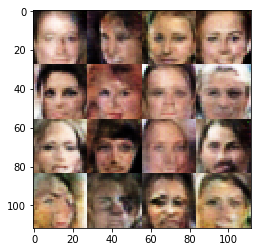

Epoch 2/2... Discriminator Loss: 0.0538... Generator Loss: 4.2205
Epoch 2/2... Discriminator Loss: 0.7566... Generator Loss: 0.9097
Epoch 2/2... Discriminator Loss: 0.3298... Generator Loss: 1.8024
Epoch 2/2... Discriminator Loss: 0.2092... Generator Loss: 2.0764
Epoch 2/2... Discriminator Loss: 0.0302... Generator Loss: 7.5939
Epoch 2/2... Discriminator Loss: 0.0433... Generator Loss: 4.1179
Epoch 2/2... Discriminator Loss: 0.4176... Generator Loss: 1.6154
Epoch 2/2... Discriminator Loss: 0.1501... Generator Loss: 2.6130
Epoch 2/2... Discriminator Loss: 0.0912... Generator Loss: 3.2954
Epoch 2/2... Discriminator Loss: 0.1201... Generator Loss: 4.6703
3


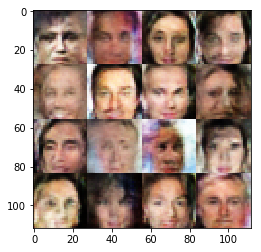

Epoch 2/2... Discriminator Loss: 3.9360... Generator Loss: 0.0597
Epoch 2/2... Discriminator Loss: 0.5199... Generator Loss: 1.7164
Epoch 2/2... Discriminator Loss: 0.1024... Generator Loss: 3.2791
Epoch 2/2... Discriminator Loss: 0.1405... Generator Loss: 2.6541
Epoch 2/2... Discriminator Loss: 0.0975... Generator Loss: 3.8745
Epoch 2/2... Discriminator Loss: 0.0557... Generator Loss: 5.1252
Epoch 2/2... Discriminator Loss: 0.1495... Generator Loss: 6.1989
Epoch 2/2... Discriminator Loss: 0.0557... Generator Loss: 4.7867
Epoch 2/2... Discriminator Loss: 1.7146... Generator Loss: 0.3474
Epoch 2/2... Discriminator Loss: 0.8664... Generator Loss: 2.5082
3


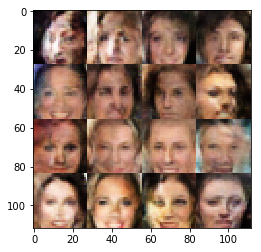

Epoch 2/2... Discriminator Loss: 1.0451... Generator Loss: 0.9705
Epoch 2/2... Discriminator Loss: 0.7391... Generator Loss: 1.0374
Epoch 2/2... Discriminator Loss: 0.4078... Generator Loss: 1.9650
Epoch 2/2... Discriminator Loss: 0.6344... Generator Loss: 3.8929
Epoch 2/2... Discriminator Loss: 1.9381... Generator Loss: 3.9289
Epoch 2/2... Discriminator Loss: 1.5832... Generator Loss: 0.4433
Epoch 2/2... Discriminator Loss: 0.3261... Generator Loss: 2.6884
Epoch 2/2... Discriminator Loss: 0.2456... Generator Loss: 3.8815
Epoch 2/2... Discriminator Loss: 0.0857... Generator Loss: 4.8780
Epoch 2/2... Discriminator Loss: 0.1832... Generator Loss: 2.3633
3


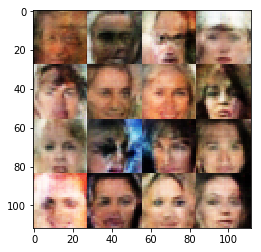

Epoch 2/2... Discriminator Loss: 0.6348... Generator Loss: 1.1878
Epoch 2/2... Discriminator Loss: 0.1614... Generator Loss: 2.4436
Epoch 2/2... Discriminator Loss: 0.3315... Generator Loss: 4.8871
Epoch 2/2... Discriminator Loss: 0.2083... Generator Loss: 2.3112
Epoch 2/2... Discriminator Loss: 0.6233... Generator Loss: 1.6569
Epoch 2/2... Discriminator Loss: 0.3819... Generator Loss: 1.6093
Epoch 2/2... Discriminator Loss: 3.3678... Generator Loss: 6.0767
Epoch 2/2... Discriminator Loss: 0.4808... Generator Loss: 1.5834
Epoch 2/2... Discriminator Loss: 0.0807... Generator Loss: 4.1231
Epoch 2/2... Discriminator Loss: 0.0903... Generator Loss: 3.4290
3


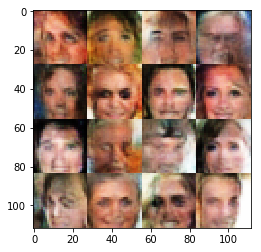

Epoch 2/2... Discriminator Loss: 0.3562... Generator Loss: 1.7043
Epoch 2/2... Discriminator Loss: 0.4659... Generator Loss: 2.6311
Epoch 2/2... Discriminator Loss: 0.6971... Generator Loss: 1.1073
Epoch 2/2... Discriminator Loss: 0.8892... Generator Loss: 0.8797
Epoch 2/2... Discriminator Loss: 0.1171... Generator Loss: 2.9861
Epoch 2/2... Discriminator Loss: 0.6053... Generator Loss: 1.0624
Epoch 2/2... Discriminator Loss: 0.2701... Generator Loss: 1.8074
Epoch 2/2... Discriminator Loss: 0.0418... Generator Loss: 5.3337
Epoch 2/2... Discriminator Loss: 0.0805... Generator Loss: 3.6728
Epoch 2/2... Discriminator Loss: 0.0955... Generator Loss: 4.0740
3


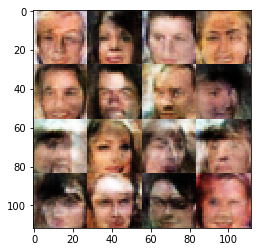

Epoch 2/2... Discriminator Loss: 2.6283... Generator Loss: 6.5508
Epoch 2/2... Discriminator Loss: 0.5405... Generator Loss: 1.7699
Epoch 2/2... Discriminator Loss: 0.5332... Generator Loss: 1.5752
Epoch 2/2... Discriminator Loss: 0.4104... Generator Loss: 1.7149
Epoch 2/2... Discriminator Loss: 0.7165... Generator Loss: 2.5208
Epoch 2/2... Discriminator Loss: 0.5519... Generator Loss: 1.5084
Epoch 2/2... Discriminator Loss: 0.4500... Generator Loss: 5.3843
Epoch 2/2... Discriminator Loss: 0.6673... Generator Loss: 1.1682
Epoch 2/2... Discriminator Loss: 0.2619... Generator Loss: 1.9221
Epoch 2/2... Discriminator Loss: 0.1876... Generator Loss: 4.1199
3


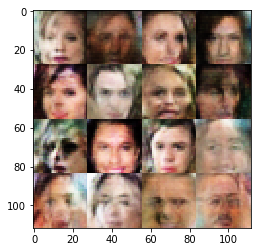

Epoch 2/2... Discriminator Loss: 2.5981... Generator Loss: 0.1474
Epoch 2/2... Discriminator Loss: 0.5531... Generator Loss: 2.0102
Epoch 2/2... Discriminator Loss: 0.2728... Generator Loss: 2.0254
Epoch 2/2... Discriminator Loss: 1.8389... Generator Loss: 0.2831
Epoch 2/2... Discriminator Loss: 0.6446... Generator Loss: 1.2974
Epoch 2/2... Discriminator Loss: 0.2003... Generator Loss: 2.5923
Epoch 2/2... Discriminator Loss: 0.0850... Generator Loss: 4.6133
Epoch 2/2... Discriminator Loss: 0.0663... Generator Loss: 4.3023
Epoch 2/2... Discriminator Loss: 0.4563... Generator Loss: 1.4279
Epoch 2/2... Discriminator Loss: 1.7353... Generator Loss: 0.4618
3


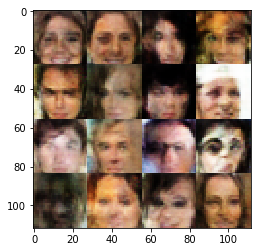

Epoch 2/2... Discriminator Loss: 0.2587... Generator Loss: 2.0912
Epoch 2/2... Discriminator Loss: 0.2148... Generator Loss: 4.5540
Epoch 2/2... Discriminator Loss: 0.1575... Generator Loss: 2.9489
Epoch 2/2... Discriminator Loss: 0.1024... Generator Loss: 6.9169
Epoch 2/2... Discriminator Loss: 0.0571... Generator Loss: 3.8185
Epoch 2/2... Discriminator Loss: 0.1454... Generator Loss: 2.6091
Epoch 2/2... Discriminator Loss: 0.4372... Generator Loss: 1.6572
Epoch 2/2... Discriminator Loss: 0.7280... Generator Loss: 1.1314
Epoch 2/2... Discriminator Loss: 0.2628... Generator Loss: 2.0792
Epoch 2/2... Discriminator Loss: 0.0951... Generator Loss: 4.4086
3


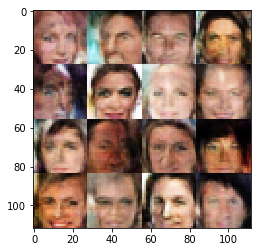

Epoch 2/2... Discriminator Loss: 0.0551... Generator Loss: 3.6801
Epoch 2/2... Discriminator Loss: 0.1780... Generator Loss: 2.3982
Epoch 2/2... Discriminator Loss: 0.0413... Generator Loss: 3.9805
Epoch 2/2... Discriminator Loss: 0.0579... Generator Loss: 4.0671
Epoch 2/2... Discriminator Loss: 0.0660... Generator Loss: 4.3349
Epoch 2/2... Discriminator Loss: 0.0505... Generator Loss: 4.6193
Epoch 2/2... Discriminator Loss: 1.1568... Generator Loss: 4.6488
Epoch 2/2... Discriminator Loss: 0.7669... Generator Loss: 3.4660
Epoch 2/2... Discriminator Loss: 0.6976... Generator Loss: 1.4256
Epoch 2/2... Discriminator Loss: 1.8157... Generator Loss: 0.3876
3


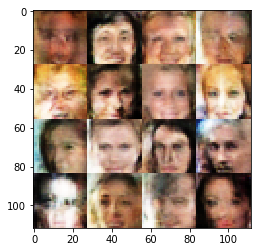

Epoch 2/2... Discriminator Loss: 0.3778... Generator Loss: 2.1535
Epoch 2/2... Discriminator Loss: 0.5150... Generator Loss: 2.3171
Epoch 2/2... Discriminator Loss: 0.8645... Generator Loss: 0.8186
Epoch 2/2... Discriminator Loss: 3.1989... Generator Loss: 0.0957
Epoch 2/2... Discriminator Loss: 0.5545... Generator Loss: 1.4253
Epoch 2/2... Discriminator Loss: 0.4385... Generator Loss: 2.2362
Epoch 2/2... Discriminator Loss: 0.5625... Generator Loss: 2.5047
Epoch 2/2... Discriminator Loss: 1.1806... Generator Loss: 0.6565
Epoch 2/2... Discriminator Loss: 0.5297... Generator Loss: 2.5284
Epoch 2/2... Discriminator Loss: 0.2942... Generator Loss: 2.1244
3


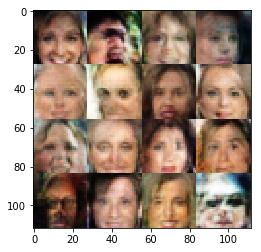

Epoch 2/2... Discriminator Loss: 0.4914... Generator Loss: 1.3710
Epoch 2/2... Discriminator Loss: 1.5192... Generator Loss: 6.0625
Epoch 2/2... Discriminator Loss: 0.5029... Generator Loss: 4.0837
Epoch 2/2... Discriminator Loss: 0.8729... Generator Loss: 0.9283
Epoch 2/2... Discriminator Loss: 0.5066... Generator Loss: 1.3555
Epoch 2/2... Discriminator Loss: 1.6864... Generator Loss: 0.2913
Epoch 2/2... Discriminator Loss: 0.1450... Generator Loss: 2.9289
Epoch 2/2... Discriminator Loss: 0.3225... Generator Loss: 2.3736
Epoch 2/2... Discriminator Loss: 0.2968... Generator Loss: 2.0497
Epoch 2/2... Discriminator Loss: 0.7840... Generator Loss: 0.9483
3


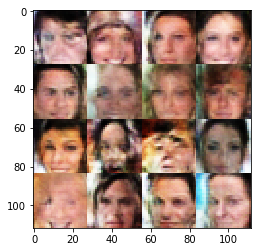

Epoch 2/2... Discriminator Loss: 0.5013... Generator Loss: 1.4457
Epoch 2/2... Discriminator Loss: 0.2227... Generator Loss: 2.1940
Epoch 2/2... Discriminator Loss: 0.1010... Generator Loss: 3.0797
Epoch 2/2... Discriminator Loss: 0.1524... Generator Loss: 2.8003
Epoch 2/2... Discriminator Loss: 0.0380... Generator Loss: 6.2344
Epoch 2/2... Discriminator Loss: 1.3952... Generator Loss: 4.7975
Epoch 2/2... Discriminator Loss: 0.6435... Generator Loss: 1.0851
Epoch 2/2... Discriminator Loss: 0.1086... Generator Loss: 3.1307
Epoch 2/2... Discriminator Loss: 0.0867... Generator Loss: 3.3890
Epoch 2/2... Discriminator Loss: 0.0683... Generator Loss: 3.3472
3


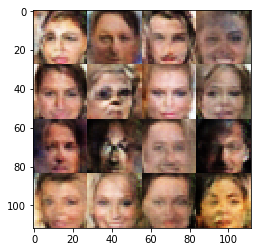

Epoch 2/2... Discriminator Loss: 0.0303... Generator Loss: 5.2128
Epoch 2/2... Discriminator Loss: 0.1060... Generator Loss: 2.9769
Epoch 2/2... Discriminator Loss: 0.1140... Generator Loss: 3.5208
Epoch 2/2... Discriminator Loss: 0.1280... Generator Loss: 3.2033
Epoch 2/2... Discriminator Loss: 0.0466... Generator Loss: 4.3918
Epoch 2/2... Discriminator Loss: 0.7301... Generator Loss: 1.0618
Epoch 2/2... Discriminator Loss: 0.8357... Generator Loss: 0.9991
Epoch 2/2... Discriminator Loss: 0.4719... Generator Loss: 1.7485
Epoch 2/2... Discriminator Loss: 0.4383... Generator Loss: 1.5543
Epoch 2/2... Discriminator Loss: 0.0967... Generator Loss: 4.1338
3


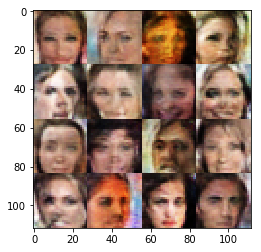

Epoch 2/2... Discriminator Loss: 0.0739... Generator Loss: 3.8924
Epoch 2/2... Discriminator Loss: 0.1379... Generator Loss: 2.7643
Epoch 2/2... Discriminator Loss: 0.0575... Generator Loss: 3.5160
Epoch 2/2... Discriminator Loss: 2.2539... Generator Loss: 0.1867
Epoch 2/2... Discriminator Loss: 0.4211... Generator Loss: 1.9237
Epoch 2/2... Discriminator Loss: 0.2451... Generator Loss: 2.5267
Epoch 2/2... Discriminator Loss: 0.2248... Generator Loss: 2.1301
Epoch 2/2... Discriminator Loss: 0.3634... Generator Loss: 3.6240
Epoch 2/2... Discriminator Loss: 0.1191... Generator Loss: 2.9369
Epoch 2/2... Discriminator Loss: 2.1068... Generator Loss: 0.2613
3


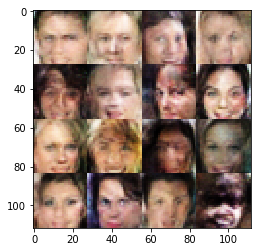

Epoch 2/2... Discriminator Loss: 1.4079... Generator Loss: 0.5151
Epoch 2/2... Discriminator Loss: 0.3578... Generator Loss: 2.4143
Epoch 2/2... Discriminator Loss: 0.2755... Generator Loss: 3.3008
Epoch 2/2... Discriminator Loss: 0.3857... Generator Loss: 2.4044
Epoch 2/2... Discriminator Loss: 0.1213... Generator Loss: 3.2443
Epoch 2/2... Discriminator Loss: 0.9510... Generator Loss: 0.7661
Epoch 2/2... Discriminator Loss: 0.4194... Generator Loss: 1.5768
Epoch 2/2... Discriminator Loss: 0.1591... Generator Loss: 2.7178
Epoch 2/2... Discriminator Loss: 0.1054... Generator Loss: 2.9511
Epoch 2/2... Discriminator Loss: 0.0525... Generator Loss: 4.5980
3


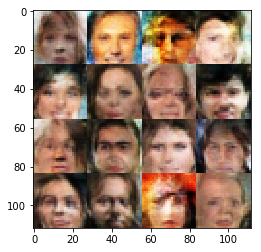

Epoch 2/2... Discriminator Loss: 0.0256... Generator Loss: 7.4019
Epoch 2/2... Discriminator Loss: 0.0363... Generator Loss: 4.7358
Epoch 2/2... Discriminator Loss: 0.0427... Generator Loss: 6.6142
Epoch 2/2... Discriminator Loss: 0.4234... Generator Loss: 2.1632
Epoch 2/2... Discriminator Loss: 0.3186... Generator Loss: 3.8619
Epoch 2/2... Discriminator Loss: 0.5595... Generator Loss: 3.1227
Epoch 2/2... Discriminator Loss: 0.2307... Generator Loss: 2.6353
Epoch 2/2... Discriminator Loss: 0.0303... Generator Loss: 5.5417
Epoch 2/2... Discriminator Loss: 3.9688... Generator Loss: 0.0436
Epoch 2/2... Discriminator Loss: 0.4377... Generator Loss: 1.5166
3


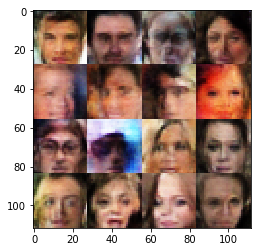

Epoch 2/2... Discriminator Loss: 0.2563... Generator Loss: 1.9632
Epoch 2/2... Discriminator Loss: 1.6494... Generator Loss: 7.3288
Epoch 2/2... Discriminator Loss: 0.1897... Generator Loss: 2.4138
Epoch 2/2... Discriminator Loss: 0.1202... Generator Loss: 4.9907
Epoch 2/2... Discriminator Loss: 0.0820... Generator Loss: 3.2476
Epoch 2/2... Discriminator Loss: 0.0932... Generator Loss: 6.2098
Epoch 2/2... Discriminator Loss: 0.0648... Generator Loss: 3.6127
Epoch 2/2... Discriminator Loss: 0.0423... Generator Loss: 4.3648
Epoch 2/2... Discriminator Loss: 0.0232... Generator Loss: 5.4438
Epoch 2/2... Discriminator Loss: 0.1097... Generator Loss: 4.5727
3


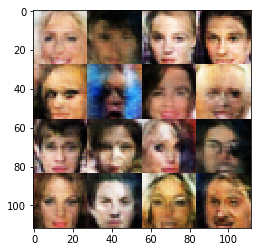

Epoch 2/2... Discriminator Loss: 0.0357... Generator Loss: 4.6099
Epoch 2/2... Discriminator Loss: 0.0778... Generator Loss: 5.9134
Epoch 2/2... Discriminator Loss: 0.2676... Generator Loss: 1.9113
Epoch 2/2... Discriminator Loss: 0.0585... Generator Loss: 6.8168
Epoch 2/2... Discriminator Loss: 0.0188... Generator Loss: 7.2133
Epoch 2/2... Discriminator Loss: 0.0282... Generator Loss: 4.6640
Epoch 2/2... Discriminator Loss: 2.5459... Generator Loss: 7.9523
Epoch 2/2... Discriminator Loss: 1.0280... Generator Loss: 4.2353
Epoch 2/2... Discriminator Loss: 1.1556... Generator Loss: 5.1396
Epoch 2/2... Discriminator Loss: 0.6675... Generator Loss: 1.0960
3


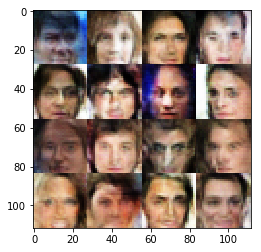

KeyboardInterrupt: 

In [135]:
batch_size = 64
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.